In [ ]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn
from module import ImageVAE
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import os

In [24]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
INPUT_DIM = 28**2
H_DIM = 200
Z_DIM = 20

NUM_EPOCHS = 15
BATCH_SIZE = 128
LR_RATE = 3e-4

OUTPUT_DIR = 'generated'



cpu


In [ ]:
# Dataset Loading
dataset = datasets.MNIST(root="datasets/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ImageVAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction='sum') # MSE_loss or ABS_loss may also work


469it [00:03, 139.78it/s, loss=3.58e+3]
469it [00:03, 144.74it/s, loss=3.69e+3]
469it [00:03, 149.91it/s, loss=2.67e+3]
469it [00:03, 145.12it/s, loss=2.13e+3]
469it [00:03, 147.98it/s, loss=2.15e+3]
469it [00:03, 145.57it/s, loss=1.73e+3]
469it [00:03, 145.36it/s, loss=1.37e+3]
469it [00:03, 139.00it/s, loss=1.37e+3]
469it [00:03, 143.29it/s, loss=1.6e+3] 
469it [00:03, 148.86it/s, loss=1.09e+3]
469it [00:03, 146.12it/s, loss=1.11e+3]
469it [00:03, 154.39it/s, loss=936]    
469it [00:03, 150.25it/s, loss=1.8e+3] 
469it [00:03, 153.93it/s, loss=1.45e+3]
469it [00:03, 149.13it/s, loss=609]    


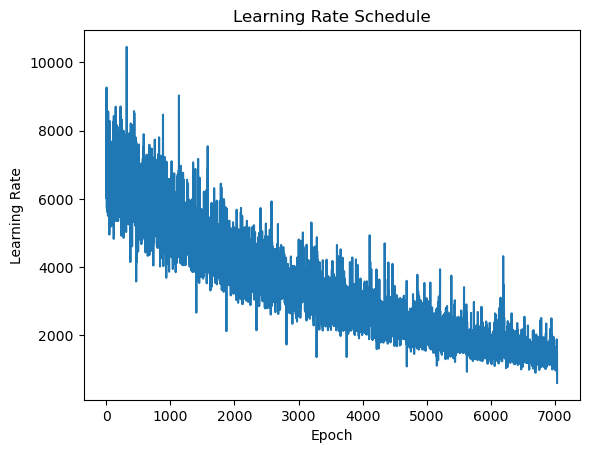

In [ ]:
# Start Training
lrs = []
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        # Forward Pass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)

        # Compute Loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Backpropagate Error
        loss = reconstruction_loss * kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
        lrs.append(loss.item())


        
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Rate Schedule')
plt.show()

        



In [19]:
model = model.to(DEVICE)
def inference(digit, num_examples=1):
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1

        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))
    

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated/{digit}_ex{example}.png")


In [31]:
# Clean Generated Images
for filename in os.listdir(OUTPUT_DIR):
    file_path = os.path.join(OUTPUT_DIR, filename)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except OSError as e:
            print(f"Error deleting file {file_path}: {e}")
    else:
        print(f"Skilling non-file item: {file_path}")


In [29]:

for idx in range(10):
    inference(idx, num_examples=3)
